In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0y1eeetVIeftVB2mSPaS")
project = rf.workspace("migo-0m9hc").project("car-colors-1smyc-8m2ac")
version = project.version(2)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Car-Colors-2 in folder:: 100%|██████████| 2036/2036 [00:00<00:00, 10162.62it/s]


In [ ]:
datadir='/content/Car-Colors-2'
traindir='/content/Car-Colors-2/train'
testdir='/content/Car-Colors-2/test'
valdir='/content/Car-Colors-2/valid'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import make_grid
import torchvision.models as models

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

Поскольку я добавила предобработку в робофлоу, ресайз тут я не делала

In [ ]:
train_transform = v2.Compose([v2.RandomHorizontalFlip(0.25),
                              v2.RandomRotation(5),
                              v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
transform = v2.Compose([v2.ToImage(),
                        v2.ToDtype(torch.float32, scale=True)])

In [ ]:
train_dataset=datasets.ImageFolder(traindir,transform=train_transform)
test_dataset=datasets.ImageFolder(testdir,transform=transform)
val_dataset=datasets.ImageFolder(valdir,transform=transform)

In [ ]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

lb=train_dataset.targets
lb=np.array(lb)
np.unique(lb,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([171, 167, 134, 157, 164, 163, 142, 144, 154]))

torch.Size([32, 3, 244, 244])


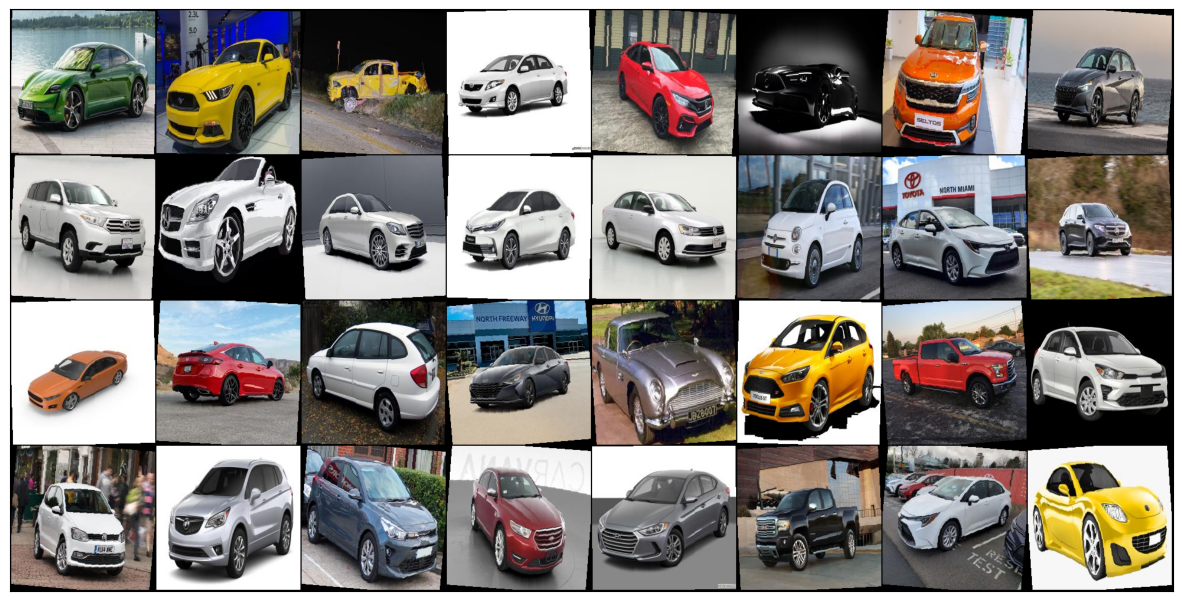

In [ ]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)
show_batch(train_loader)

In [ ]:
! pip install efficientnet_pytorch

In [ ]:
! pip install torchinfo

In [ ]:
from efficientnet_pytorch import EfficientNet
from torchinfo import summary
model = EfficientNet.from_pretrained('efficientnet-b0')
model.to(device);

Loaded pretrained weights for efficientnet-b0


In [ ]:
from torchinfo import summary
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 9]                    --
├─Conv2dStaticSamePadding: 1-1                     [1, 32, 112, 112]         864
│    └─ZeroPad2d: 2-1                              [1, 3, 225, 225]          --
├─BatchNorm2d: 1-2                                 [1, 32, 112, 112]         64
├─MemoryEfficientSwish: 1-3                        [1, 32, 112, 112]         --
├─ModuleList: 1-4                                  --                        --
│    └─MBConvBlock: 2-2                            [1, 16, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-1           [1, 32, 112, 112]         288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         64
│    │    └─MemoryEfficientSwish: 3-3              [1, 32, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-4           [1, 8, 1, 1]              264
│    │    └─MemoryEfficientSwish

In [ ]:
num_cls=len(train_dataset.classes)
model._fc=nn.Linear(1280,num_cls)
model.to(device);
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 9]                    --
├─Conv2dStaticSamePadding: 1-1                     [1, 32, 112, 112]         864
│    └─ZeroPad2d: 2-1                              [1, 3, 225, 225]          --
├─BatchNorm2d: 1-2                                 [1, 32, 112, 112]         64
├─MemoryEfficientSwish: 1-3                        [1, 32, 112, 112]         --
├─ModuleList: 1-4                                  --                        --
│    └─MBConvBlock: 2-2                            [1, 16, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-1           [1, 32, 112, 112]         288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         64
│    │    └─MemoryEfficientSwish: 3-3              [1, 32, 112, 112]         --
│    │    └─Conv2dStaticSamePadding: 3-4           [1, 8, 1, 1]              264
│    │    └─MemoryEfficientSwish

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
!pip install pytorch-ignite --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.2/343.2 kB 9.5 MB/s eta 0:00:00


In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=num_cls)}
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(val_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [ ]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

/usr/local/lib/python3.11/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

# Ради интереса взяла 10 эпох, но после 6 модель явно начала переобучаться

  2%|2         | 1/44 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 94.48 Сред. ошибка: 0.16179
Результат валидации - Эпоха: 6  Сред. точность: 79.49 Сред. ошибка: 0.68243


  2%|2         | 1/44 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 94.05 Сред. ошибка: 0.18818
Результат валидации - Эпоха: 7  Сред. точность: 83.04 Сред. ошибка: 0.73618


  2%|2         | 1/44 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 91.12 Сред. ошибка: 0.23642
Результат валидации - Эпоха: 8  Сред. точность: 80.00 Сред. ошибка: 0.90408


  2%|2         | 1/44 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 96.78 Сред. ошибка: 0.12437
Результат валидации - Эпоха: 9  Сред. точность: 82.03 Сред. ошибка: 0.80725


  2%|2         | 1/44 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 91.98 Сред. ошибка: 0.36801
Результат валидации - Эпоха: 10  Сред. точность: 75.95 Сред. ошибка: 1.45809


State:
	iteration: 440
	epoch: 10
	epoch_length: 44
	max_epochs: 10
	output: 0.404379665851593
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

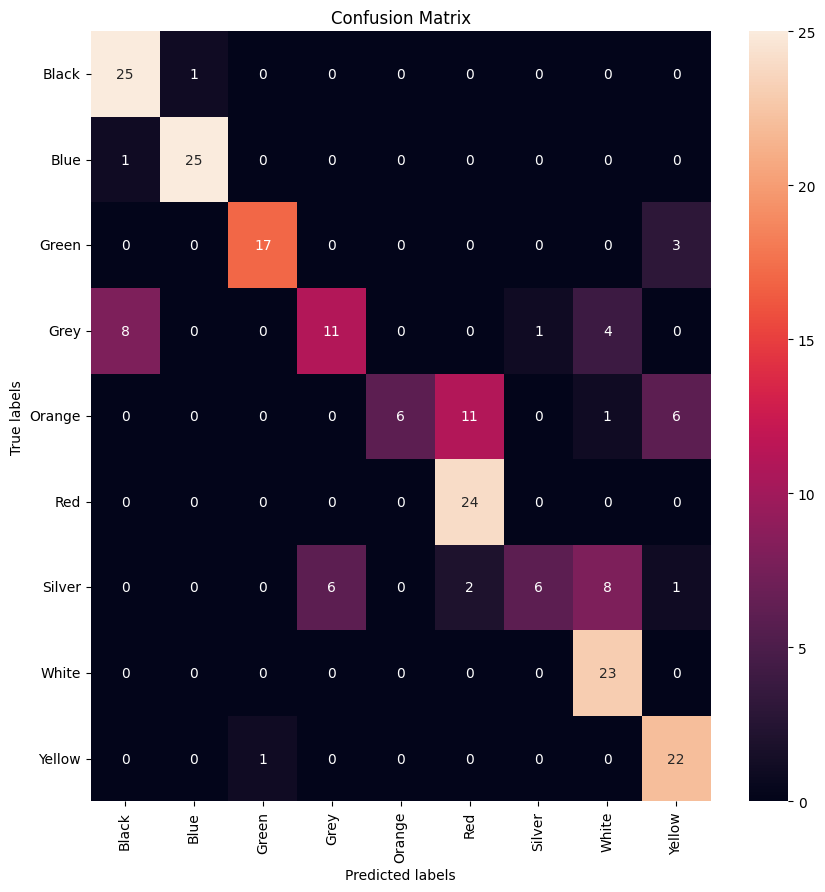

In [ ]:
trainer.run(train_loader, max_epochs=10)

## Путает серые с черными и серебристыми, и оранжевые с желтыми

In [ ]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


In [ ]:
def get_preds(model, loader, device):
  model.eval()
  y_true = torch.tensor([], dtype=torch.long, device=device)
  all_outputs = torch.tensor([], device=device)

  with torch.no_grad():
      for data in test_loader:
          inputs = [i.to(device) for i in data[:-1]]
          labels = data[-1].to(device)

          outputs = model(*inputs)
          y_true = torch.cat((y_true, labels), 0)
          all_outputs = torch.cat((all_outputs, outputs), 0)

      y_true = y_true.cpu().numpy()
      _, y_pred = torch.max(all_outputs, 1)
      y_pred = y_pred.cpu().numpy()
      y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()

  return y_true, y_pred, y_pred_prob

In [ ]:
y_true, y_pred, _ = get_preds(model, test_loader, device)

In [ ]:
from sklearn.metrics import matthews_corrcoef, classification_report

In [ ]:
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

       Black       0.83      0.92      0.87        26
        Blue       0.86      0.92      0.89        26
       Green       0.90      0.95      0.93        20
        Grey       0.67      0.58      0.62        24
      Orange       0.96      0.92      0.94        24
         Red       0.91      0.88      0.89        24
      Silver       0.88      0.30      0.45        23
       White       0.59      1.00      0.74        23
      Yellow       1.00      0.91      0.95        23

    accuracy                           0.82       213
   macro avg       0.84      0.82      0.81       213
weighted avg       0.84      0.82      0.81       213



In [ ]:
matthews_corrcoef(y_true,y_pred)

np.float64(0.8042379968632788)

## Коэффициент показывает, что предсказание близко к правильному и точно не случайно